#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.sort_index(inplace=True)

In [6]:
data.index.is_monotonic

True

In [7]:
data_11 = data.copy()
data_12 = data.copy()
data_13 = data.copy()
data = round(data.resample('1H').sum())
data_day = round(data_11.resample('D').sum())
data_week = round(data_12.resample('W').sum())
data_month = round(data_12.resample('M').sum())

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
data1 = data.copy()
data2 = data.copy()

Загружены данные о количестве заказов такси. Данные о количестве заказов представлены с начала марта 2018 года по конец агуста 2018 года. Данные не имеют пропусков. Даты переведены в формат Datetime. Датасет отсортирован по убыванию дат. Данные ресемплированы в размере 1 часа.

## Анализ

<AxesSubplot:xlabel='datetime'>

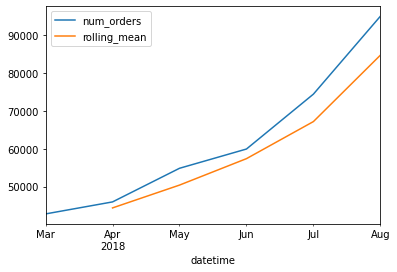

In [10]:
data_month['rolling_mean'] = data_month.rolling(2).mean()
data_month.plot()

In [11]:
data_month=data_month.drop('rolling_mean', axis=1)

<AxesSubplot:xlabel='datetime'>

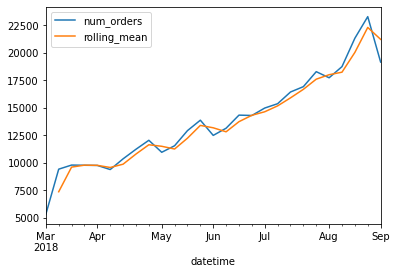

In [12]:
data_week['rolling_mean'] = data_week.rolling(2).mean()
data_week.plot()

<AxesSubplot:xlabel='datetime'>

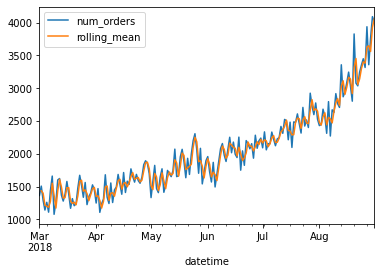

In [13]:
data_day['rolling_mean'] = data_day.rolling(2).mean()
data_day.plot()

<AxesSubplot:xlabel='datetime'>

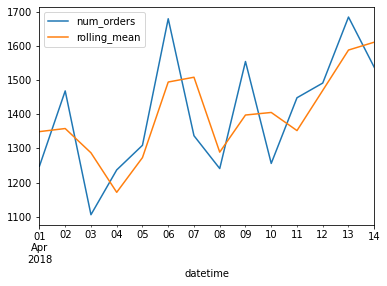

In [14]:
data_day['2018-04-01':'2018-04-14'].plot()

In [15]:
data_day = data_day.drop('rolling_mean', axis=1)

In [16]:
decomposed = seasonal_decompose(data_day)

Text(0.5, 1.0, 'Trend day')

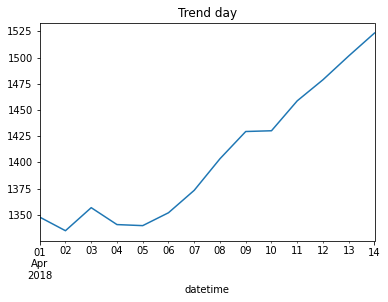

In [17]:
decomposed.trend['2018-04-01':'2018-04-14'].plot(ax=plt.gca())
plt.title('Trend day')

Text(0.5, 1.0, 'Seasonality day')

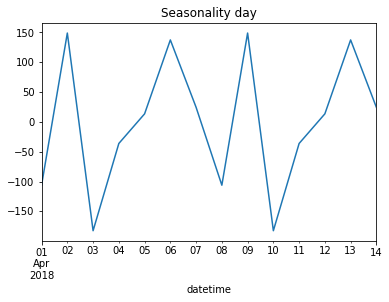

In [18]:
decomposed.seasonal['2018-04-01':'2018-04-14'].plot(ax=plt.gca())
plt.title('Seasonality day')

<AxesSubplot:xlabel='datetime'>

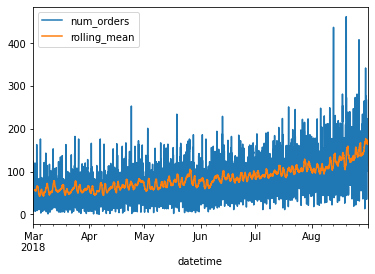

In [19]:
data['rolling_mean'] = data.rolling(24).mean()
data.plot()

<AxesSubplot:xlabel='datetime'>

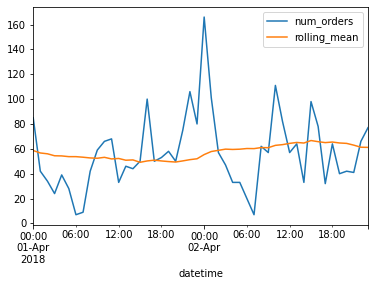

In [20]:
data['2018-04-01':'2018-04-02'].plot()

In [21]:
data=data.drop('rolling_mean', axis=1)

In [22]:
decomposed = seasonal_decompose(data)

Text(0.5, 1.0, 'Trend hour')

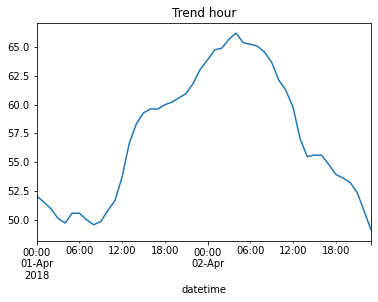

In [23]:
decomposed.trend['2018-04-01':'2018-04-02'].plot(ax=plt.gca())
plt.title('Trend hour')

Text(0.5, 1.0, 'Seasonality day')

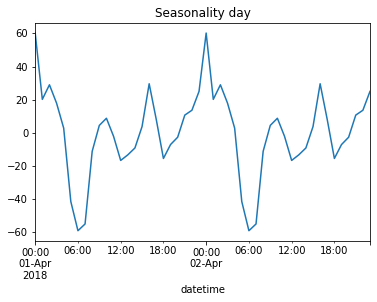

In [24]:
decomposed.seasonal['2018-04-01':'2018-04-02'].plot(ax=plt.gca())
plt.title('Seasonality day')

Количество заказов такси имеет тренд к росту от марта к августу с незначительными спадами, в начале всех месяцев и середине некоторых месяцев. Анализ недельных колебаний количества заказов говорит о 2-х пиках заказов (пятница и понедельник) в неделю и 2-х спадах (воскресение и вторник). Анализ колебаний количества заказов в течении суток показывает большой минимум заказов в 6 утра  2 маленьких минимума в 12 и 12 часов. Большой пик в 12 часов ночи и 2 малых пика в 10 утра и 16 часов дня. 

## Обучение

In [25]:
score = make_scorer(mean_squared_error, greater_is_better=True)

In [26]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [27]:
data3 = data.copy()

In [28]:
make_features(data3, 1, 25)
train, test = train_test_split(data3, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train[['num_orders']]
test_features = test.drop(['num_orders'], axis=1)
test_target = test[['num_orders']]
model = LinearRegression() 
model.fit(train_features, train_target)
cv_result = cross_validate(model, train_features, train_target, scoring=score, cv=5)
rmse = cv_result['test_score'].mean()**0.5


print('RMSE линейная регрессия', rmse)

RMSE линейная регрессия 30.9747019636723


In [29]:
train

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-02 01:00:00,120,4,1,90.0,58.16
2018-03-02 02:00:00,75,4,2,120.0,58.00
2018-03-02 03:00:00,64,4,3,75.0,57.60
2018-03-02 04:00:00,20,4,4,64.0,57.32
2018-03-02 05:00:00,11,4,5,20.0,55.48
...,...,...,...,...,...
2018-08-13 09:00:00,137,0,9,91.0,132.56
2018-08-13 10:00:00,156,0,10,137.0,134.16
2018-08-13 11:00:00,144,0,11,156.0,136.08


In [30]:
param_set = {
 'n_estimators':[70, 80, 90, 100, 120, 150],
 'max_depth': [8, 9, 10, 12, 15]
}

In [31]:
data4 = data.copy()

In [32]:
make_features(data4, 1, 25)
train, test = train_test_split(data4, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train[['num_orders']]
test_features = test.drop(['num_orders'], axis=1)
test_target = test[['num_orders']]

model_rf = RandomForestRegressor(random_state=12345) 
model_rf = GridSearchCV(model_rf, param_grid = param_set, cv=5, scoring = score)
model_rf.fit(train_features, train_target)
rmse_rf = model_rf.score(train_features, train_target)**0.5

print('RMSE случайный лес', rmse_rf)

RMSE случайный лес 19.72622413087037


In [33]:
max_depth = model_rf.best_params_['max_depth']
n_estimators = model_rf.best_params_['n_estimators']

In [34]:
model_rf.best_params_

{'max_depth': 8, 'n_estimators': 70}

Создадим дополнительные признаки (сдивинутые данные о заказах и скользящее среднее) для обучения моделей машинного обрученияю. Обучим модели линиейной регрессии и случайного леса. Для модели случайного леса подберем гиперпараметры. Сохраним подобранные параметры случайного леса для дальнейшего  создания модели случайного леса. Кросс-валидируем модели. RMSE линейной регрессии 31 заказа. RMSE случайного леса 20 заказов.

## Тестирование

In [35]:
data5 = data.copy()
make_features(data5, 1, 25)
train, test = train_test_split(data5, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train[['num_orders']]
test_features = test.drop(['num_orders'], axis=1)
test_target = test[['num_orders']]
model = LinearRegression() 
model.fit(train_features, train_target)

LinearRegression()

In [36]:
data6 = data.copy()
make_features(data6, 1, 25)
train_1, test_1 = train_test_split(data6, shuffle=False, test_size=0.1)
train_1 = train_1.dropna()

train_features_1 = train_1.drop(['num_orders'], axis=1)
train_target_1 = train_1[['num_orders']]
test_features_1 = test_1.drop(['num_orders'], axis=1)
test_target_1 = test_1[['num_orders']]
model_rf = RandomForestRegressor(random_state=12345)
model_rf = GridSearchCV(model_rf, param_grid = param_set, cv=5, scoring = score)
model_rf.fit(train_features_1, train_target_1)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [8, 9, 10, 12, 15],
                         'n_estimators': [70, 80, 90, 100, 120, 150]},
             scoring=make_scorer(mean_squared_error))

In [37]:
predict_test = model.predict(test_features)
rmse_test = mean_squared_error(test_target, predict_test, squared=False)
print(rmse_test)
predict_test = pd.Series(data = predict_test[:,0],dtype='int32', index=test_target.index, name = 'predict_num_orders')
predict_targert_test = pd.concat([predict_test, test_target], axis=1)


50.95960724526439


<AxesSubplot:xlabel='datetime'>

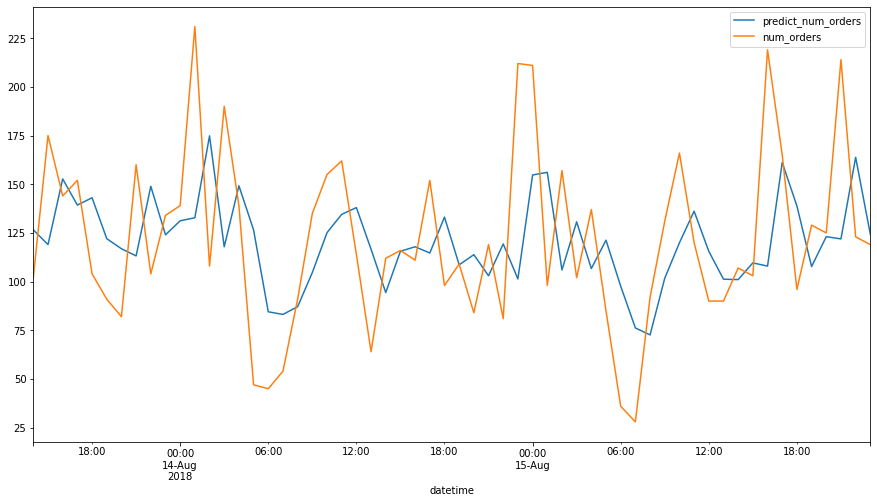

In [38]:
predict_targert_test['2018-08-13':'2018-08-15'].plot(figsize=(15, 8))

In [39]:
predict_test_rf = model_rf.predict(test_features_1)
rmse_test_rf = mean_squared_error(test_target_1, predict_test_rf, squared=False)
print(rmse_test_rf)
predict_test_rf
predict_test_rf = pd.Series(predict_test_rf, index=test_target_1.index, name = 'predict_num_orders')
predict_targert_test_rf = pd.concat([predict_test_rf, test_target_1], axis=1)


47.67285086659229


<AxesSubplot:xlabel='datetime'>

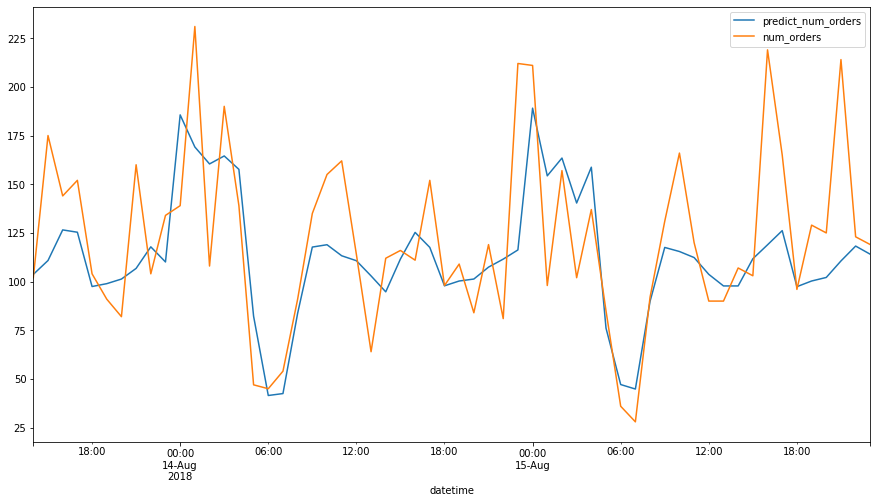

In [40]:
predict_targert_test_rf['2018-08-13':'2018-08-15'].plot(figsize=(15, 8))

In [41]:
dr = DummyRegressor()
dr.fit(train_features, train_target)
dr_predict = dr.predict(test_features)
dr_rmse = mean_squared_error(test_target, dr_predict, squared=False)
print(dr_rmse)

84.65205585624815


На тестовой выборке модели показали следующие результаты RMSE. Линейная регрессия - 51 заказ, Случайный лес - 48 заказов, Случайный регрессор - 85 заказов. Для предсказаний количества заказов такси предлагается использовать модель случайного леса (деревьям входящим в него лучше удается предсказать пики заказов).

Вывод по проекту.<br> Представлены данные о заказах такси с марта 2018 по август 2018. Данные ресемлированы в размере 1 дня.<br> Количество заказов имеет тренд к росту. Количество заказов падает в начале каждого месяца и в середине некоторых месяцев. Пиковыми днями для заказов являются пятница и понедельник. Наибольший спад в заказах отмечается в воскресение и вторник. Пиковыми часами заказа такси является 10 часов утра, 16 часов дня и 12 часов ночи, пиковыми спадами в заказах являются 6 часов утра, 12 часов дня и 18 часов вечера.<br> Подготовлены признаки для обучения моделей. Обучены модели линейной регрессии и случайного леса. Для модели случайного леса подобраны гиперпараметры. Лучшую метрику RMSE на обучающей выборке показала модель случайного леса - 20 заказов. На тестовых данных лучшую метрику показала модель случайного леса - 48 заказов (из-за лучшей адаптации модели к резкому росту целевого признака).<br> Предлагается к использованию предсказания количества заказов такси модель случайного леса.